<a href="https://colab.research.google.com/github/mc-friday/hanghaeAI/blob/main/%5B4%EC%A3%BC%EC%B0%A8%5D%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [4주차] 심화과제: 수능 국어 문제 GPT-4로 풀어보기

In [ ]:
!pip install openai

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum-coding.
(Reading database ... 123657 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 1. 수능 문제 JSON 데이터 로드 함수

In [ ]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

## 2. 하나의 문제에 대해서 GPT-4의 예측 결과를 내놓는 함수

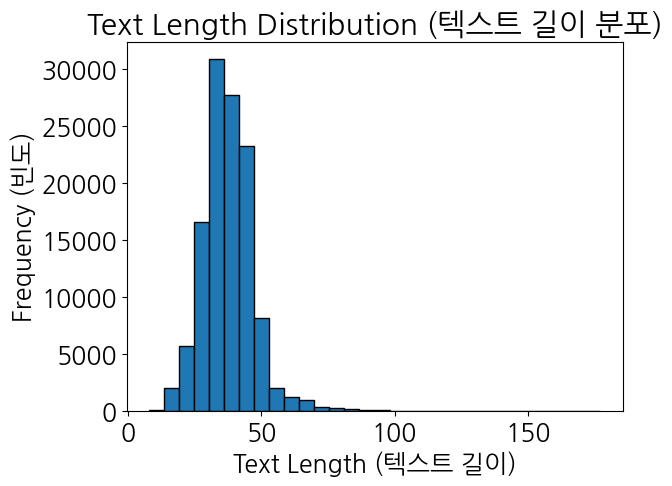

In [ ]:
def prediction(problem):
    """
    문제 데이터를 받아 GPT-4가 답안을 예측하도록 하는 함수
    """
    # And if there is content in More info, you must also refer to More info to choose an answer.
    # GPT-4에 전달할 프롬프트 템플릿 (일부러 영어를 사용함)
    zero_shot_cot_en_prompt_plus = f"""
    국어 시험 문제를 푸는 똑똑한 학생으로서 다음 문제의 답을 구하세요.
    지문을 읽고, 질문에 대한 답을 1부터 5까지의 선택지 중에 한 개만 골라서 대답해야 합니다.
    <보기>가 있으면 꼭 문제 풀이에 참고해야 합니다.

    지문 :
    {problem['paragraph']}

    질문 :
    {problem['question']}

    <보기> :
    {problem.get('question_plus', '')}

    선택지 :
    1 - {problem['choices'][0]}
    2 - {problem['choices'][1]}
    3 - {problem['choices'][2]}
    4 - {problem['choices'][3]}
    5 - {problem['choices'][4]}

    1번, 2번, 3번, 4번, 5번 중에 하나를 정답으로 고르세요.
    단계별로 생각하며 정답을 고르세요.
    정답은 숫자만 답하세요.
    정답:
    """

     # 문제 풀이 시작 시간 기록
    start_time = time.time()


    # GPT-4 API 호출
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": zero_shot_cot_en_prompt_plus}
            ]
        )
        # GPT-4의 답변에서 선택한 답안을 반환
        predicted_answer = response.choices[0].message.content

         # 문제 풀이 종료 시간 기록
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"[LOG] 문제 풀이 시간: {elapsed_time:.2f}초, 예측된 정답: {predicted_answer}")

        return predicted_answer
    except Exception as e:
        print(f"Error during GPT-4 prediction: {e}")
        return None


## 3. 모든 문제를 평가하고 점수를 계산하는 함수

In [ ]:
def evaluate_all_problems(data):
    """
    JSON 데이터의 모든 문제를 평가하고 점수를 계산하는 함수
    """
    total_score = 0  # 총 점수
    possible_score = 0  # 가능한 총 점수
    correct_count = 0  # 정답 개수
    total_count = 0  # 전체 문제 수

    for item in data:
        paragraph = item["paragraph"]
        for problem in item["problems"]:
            total_count += 1
            possible_score += problem["score"]  # 가능한 점수 누적

            # 문제 데이터 준비
            problem_data = {
                "paragraph": paragraph,
                "question": problem["question"],
                "choices": problem["choices"],
                "question_plus": problem.get("question_plus", ""),
            }

            # GPT-4 답안 예측
            predicted_answer = prediction(problem_data)

            # 실제 정답과 비교
            if str(predicted_answer) == str(problem["answer"]):  # 정답 비교
                total_score += problem["score"]
                correct_count += 1

    # 결과 출력
    print(f"총 문제 수: {total_count}")
    print(f"정답 개수: {correct_count}/{total_count}")
    print(f"정확도: {correct_count / total_count:.2%}")
    print(f"총 점수: {total_score}/{possible_score}")
    return total_score, possible_score, correct_count, total_count

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## 4. 평가 실행

In [ ]:
file_path = "./data/2023_11_KICE.json"  # Colab에 업로드한 JSON 파일 경로

# 데이터 로드
data = load_data(file_path)

# 모든 문제 평가 실행
total_score, possible_score, correct_count, total_count = evaluate_all_problems(data)